##  Simulating CME trajectory with RK4

In this project we attempt to create a simulation of the trajectory of a CME, by using a simplistic physical model, of treating the ejection as a matter cloud composed of identical point charged masses not interacting with one another. We create a 'grid' of initial positions on the Sun's surface, and provide each mass with a typical initial outward (radial) speed of $10^3 \frac{km}{s}$. 

The trajectories are then computed, for each mass separately, by numerically integrating the equations of motion using a nested Runge-Kutta 4 method. Here we consider the masses moving only under the influence of a central point mass (the Sun) and a dipole magnetic field adjusted to resemble that of the Sun. 

Lastly, we apply a rotation matrix (about the $z$ axis) to each step of the simulation to account for the Earth's approximately circular orbit, meaning that we elect to maintain the Earth in a fixed position and rotate everything else appropriately (we observe the CME from the Earth's reference frame).

Note that currently we have chosen to use units of length that are reduced by a factor of $10^{10}$ to avoid large numbers. The physical quantities have been made to be consistent with this system, even though some of the # labels might not be updated yet.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as itr
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm
from matplotlib.collections import PolyCollection
from tqdm import tqdm_notebook as tqdm

### Physical parameters

In [2]:
G = 6.67 * 10**(-11) * 10**(-30)   # SI to Mm
M = 1.99 * 10**30      # SI (kg)
R = 7    * 10**(-2)     # Mm
u0 = 1e-4  #* 10**7     # SI: Mm/s
Re = 149.6 * 10**(-1)    # Mm
L1 = 148.1 * 10**(-1)    # Mm
secday = 1/(60*60*24)

### Plotting a Sun

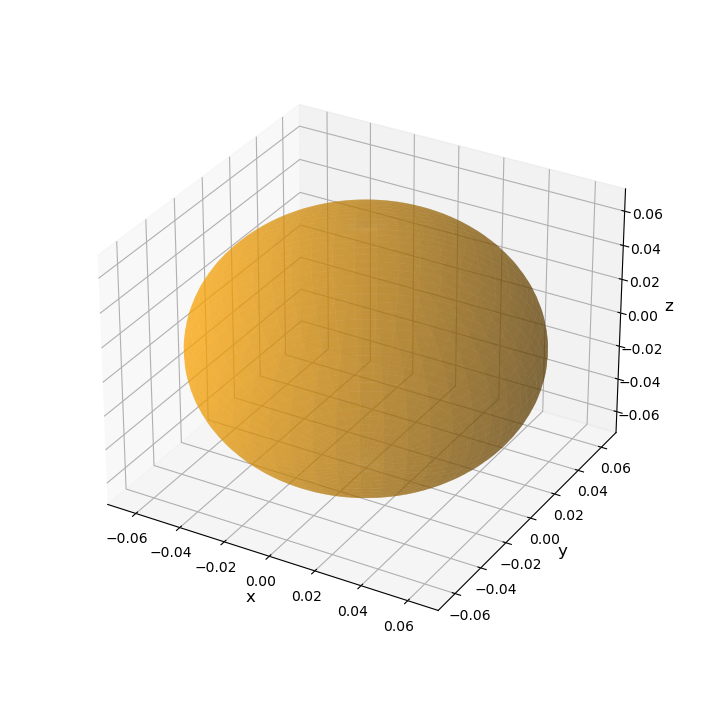

In [5]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')

# Make data
r = 10
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = R * np.outer(np.cos(u), np.sin(v))
y = R * np.outer(np.sin(u), np.sin(v))
z = R * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, color='orange', alpha=0.5)

ax.set(xlim=(-R, R), ylim=(-R, R) ,
       xlabel='Mass ($ M_o $)', ylabel='Radius ($ km $)', zlabel='log $B_s$ (G)')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)

ax.set_box_aspect(aspect=None, zoom=0.85)

## RK4 definitions

In [10]:
# nested Runge-Kutta 4 algorithm
# here the arguments x0, u0 and the resulting x, u are all vectors (three component lists)
def RK4(fx, fu, dt, t0, x0, u0):
    
    f1 = fx(t0, x0, u0)
    g1 = fu(t0, x0, u0)
    f2 = fx(t0 + dt/2 , x0 + (dt/2)*f1, u0 + (dt/2)*g1)
    g2 = fu(t0 + dt/2 , x0 + (dt/2)*f1, u0 + (dt/2)*g1)
    f3 = fx(t0 + dt/2 , x0 + (dt/2)*f2, u0 + (dt/2)*g2)
    g3 = fu(t0 + dt/2 , x0 + (dt/2)*f2, u0 + (dt/2)*g2)
    f4 = fx(t0 + dt, x0 + dt*f3, u0 + dt*g3)
    g4 = fu(t0 + dt, x0 + dt*f3, u0 + dt*g3)
    
    x1 = x0 + (dt/6)*(f1 + 2*f2 + 2*f3 + f4)
    u1 = u0 + (dt/6)*(g1 + 2*g2 + 2*g3 + g4)
    
    return [x1,u1]

In [11]:
# define forces

Mcme = 1.6e12   # CME mass (kg)
nprot = 68000    # CME number of particles in a single elementary chunk that we will treat as a point mass
mp = 1.67e-27   # proton mass (kg)
qp = 1.6e-19    # proton charge (C)
m = nprot*mp
q = nprot*qp
num = Mcme/m

B = 1e-7*1e-4    # Tesla

def gfield(x):
    dist = np.sqrt( x[0]**2 + x[1]**2 + x[2]**2 )
    return - G*M*x/(dist**3)

def bfield(x):
    dist = np.sqrt( x[0]**2 + x[1]**2 + x[2]**2 )
    rho  = np.sqrt( x[0]**2 + x[1]**2 )
    theta = np.arccos( x[2] / rho )
    phi = np.arccos( x[0] / rho )
    
    B0 = 0.5*B*(R**3)/dist**3
    
    Bx = 3*B0*np.sin(theta)*np.cos(theta)*np.cos(phi)
    By = 3*B0*np.sin(theta)*np.cos(theta)*np.sin(phi)
    Bz = B0*(3*np.cos(theta)**2 - 1)
    
    return np.array([Bx,By,Bz])

# Levi-Civita pseudotensor

def levci(a,b,c):
     
    arr=np.zeros(tuple([3 for _ in range(3)]))
    for x in itr.permutations(tuple(range(3))):
        mat = np.zeros((3, 3), dtype=np.int32)
        for i, j in zip(range(3), x):
            mat[i, j] = 1
        arr[x]=int(np.linalg.det(mat))
    
    A = arr[a]
    B = A[b]
    return B[c]

# cross product

def cross(u,v): 
    a = [0,0,0]
    
    for i in range(3):
        S = 0
        for j,k in itr.product(range(3),range(3)):
            S += levci(i,j,k)*u[j]*v[k]
        a[i] = S
    return np.array(a)

In [12]:
# define RK4 functions

def fu(t, x, u):
    
    return gfield(x) + (q/m)*cross(u,bfield(x))

def fx(t, x, u): return u

In [15]:
def simul(T, N, fu, fx): 
    
    dt = T/N
    t = np.linspace(0, T, num = N)

    X = np.zeros((3,N))
    U = np.zeros((3,N))
    X[:,0] = xinit
    U[:,0] = uinit

    xin = xinit
    uin = uinit

    for i in tqdm(range(N-1)):

        out = RK4(fx, fu, dt, t[i], xin, uin)
        xout = out[0]
        uout = out[1]
    
        X[:,i+1] = xout
        U[:,i+1] = uout
    
        xin = xout
        uin = uout
    
    return [X,U,t]

## RK4 simulation

In [14]:
# simulation parameters

Tsim = 1*2.5/secday
N = 1000

# initial conditions

xinit = np.array([R,0,0], dtype=np.float64)
uinit = np.array([u0,0.001*u0,0], dtype=np.float64)

In [16]:
sim = simul(Tsim, N, fu, fx)
X = sim[0]
U = sim[1]
t = sim[2]

C:\Users\konto\AppData\Local\Temp\ipykernel_19840\198152770.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(N-1)):


  0%|          | 0/999 [00:00<?, ?it/s]

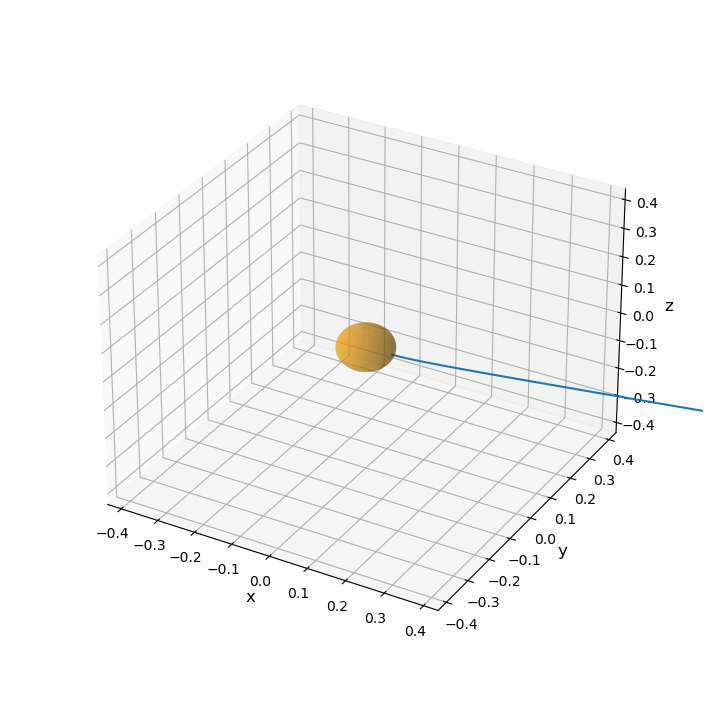

In [17]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(x, y, z, color='orange', alpha=0.5)

zer = np.zeros(len(X[0]))
ax.plot(X[0],X[1],X[2])
#print(X[0],X[1],X[2])

lim = 6*R
ax.set(xlim=(-lim, lim), ylim=(-lim, lim) , zlim=(-lim, lim),
       xlabel='Mass ($ M_o $)', ylabel='Radius ($ km $)', zlabel='log $B_s$ (G)')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)

ax.set_box_aspect(aspect=None, zoom=0.85)

In [1]:
#cut = 100
#plt.plot(X[0][:cut],X[1][:cut])
#plt.plot(t[:cut],X[0][:cut]-X[0][0])

In [2]:
#plt.plot(X[0],X[1])

## Earth

Here we define a rotation matrix $A$, which rotates our coordinate system by the angle Earth has rotated at that time.

In [18]:
Tperiod = 325.25   # days
w = 2*np.pi*secday/Tperiod

def Arot(t):
    l1 = [np.cos(w*t), -np.sin(w*t)]
    l2 = [np.sin(w*t),  np.cos(w*t)]
    return [l1,l2]

Amat = Arot(t)
#print(Amat[1])

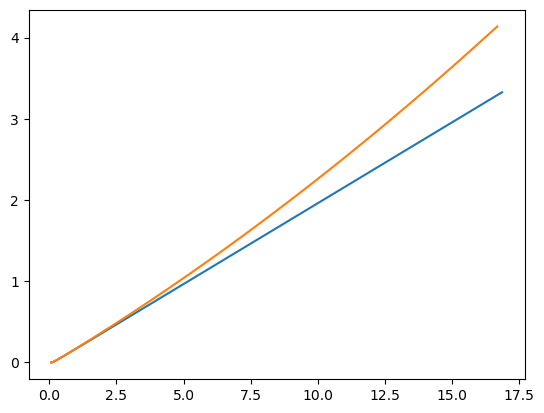

In [19]:
Xnew = np.array(Amat[0][0])*np.array(X[0]) + np.array(Amat[0][1])*np.array(X[1])
Ynew = np.array(Amat[1][0])*np.array(X[0]) + np.array(Amat[1][1])*np.array(X[1])

plt.plot(X[0],X[1])
plt.plot(Xnew,Ynew)

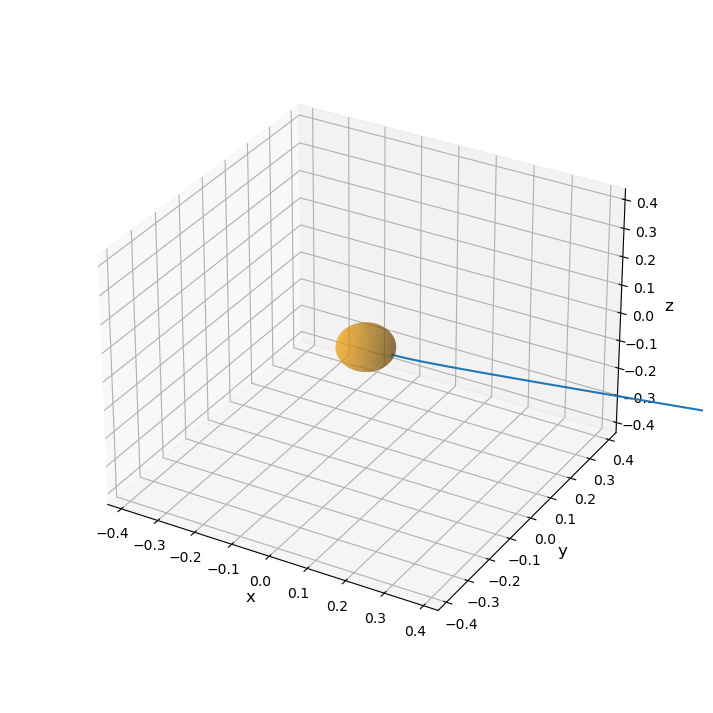

In [20]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(x, y, z, color='orange', alpha=0.5)

zer = np.zeros(len(X[0]))
ax.plot(Xnew,Ynew,X[2])
#print(X[0],X[1],X[2])

lim = 6*R
qqq = 0
ax.set(xlim=(qqq-lim, qqq+lim), ylim=(-lim, lim) , zlim=(-lim, lim),
       xlabel='Mass ($ M_o $)', ylabel='Radius ($ km $)', zlabel='log $B_s$ (G)')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)

ax.set_box_aspect(aspect=None, zoom=0.85)

## Many body

In [21]:
# initial conditions

bound = 0.1*R
step = np.linspace(-bound,bound,5)

ymgrid, zmgrid = np.meshgrid(step,step)
xmgrid = np.sqrt(R**2 - ymgrid**2 - zmgrid**2)

Xi = []
Ui = []

#print([xmgrid,ymgrid,zmgrid])

for i in range(len(step)):
    for j in range(len(step)):
        
        xi = np.array([xmgrid[i][j],ymgrid[i][j],zmgrid[i][j]], dtype=np.float64)
        Xi += [xi]
        
        #xtheta = np.arccos( xmgrid[i][j] / R )
        #xphi = np.arccos( ymgrid[i][j] / np.sqrt( R**2 - xmgrid[i][j]**2) )
        ui = xi*u0/R
        Ui += [ui]

In [22]:
Xlist = []
Ulist = []

for i in tqdm(range(len(Xi))):
    
    xinit = Xi[i]
    uinit = Ui[i]
    
    sim = simul(Tsim, N, fu, fx)
    Xlist += [sim[0]]
    Ulist += [sim[1]]
    t = sim[2]

C:\Users\konto\AppData\Local\Temp\ipykernel_19840\4050133610.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(Xi))):


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\konto\AppData\Local\Temp\ipykernel_19840\198152770.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(N-1)):


  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

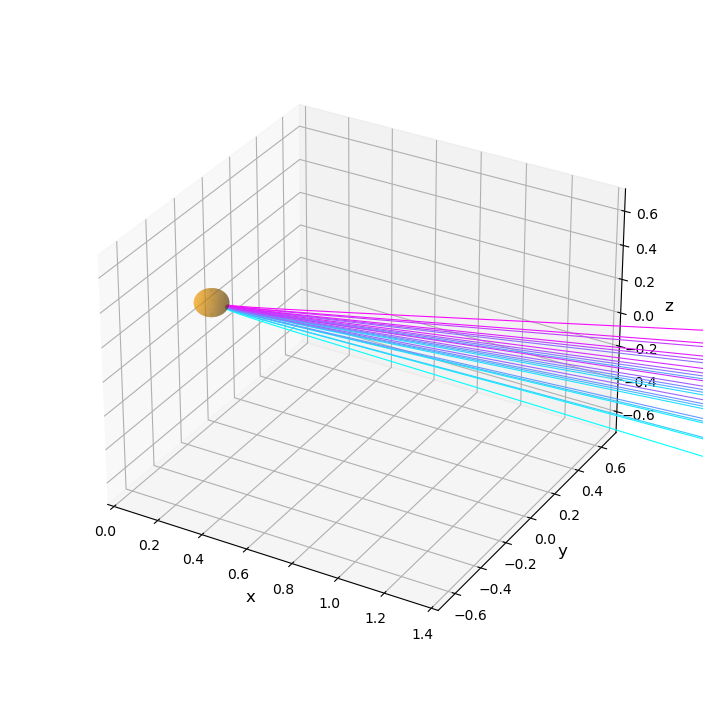

In [29]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(x, y, z, color='orange', alpha=0.5)

for i in range(len(Xlist)):    
    ax.plot(Xlist[i][0], Xlist[i][1], Xlist[i][2], c = cm.cool(i/len(Xlist)), linewidth = 0.8)
#print(X[0],X[1],X[2])

lim = 20*R
ax.set(xlim=(0, lim), ylim=(-lim/2, lim/2) , zlim=(-lim/2, lim/2),
       xlabel='Mass ($ M_o $)', ylabel='Radius ($ km $)', zlabel='log $B_s$ (G)')

ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)

ax.set_box_aspect(aspect=None, zoom=0.85)

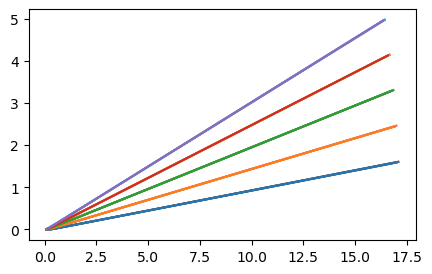

In [31]:
plt.figure(figsize = (5,3))
for i in range(len(Xlist)):    
    plt.plot(Xlist[i][0],Xlist[i][1])

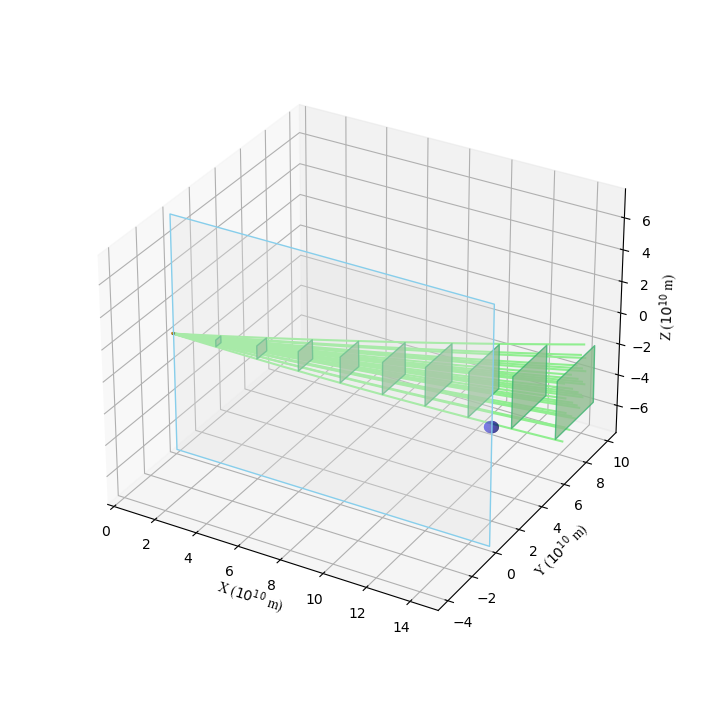

In [34]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')

# Earth
Rearth = 0.3
# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = Rearth * np.outer(np.cos(u), np.sin(v)) + Re
y = Rearth * np.outer(np.sin(u), np.sin(v))
z = Rearth * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, color='blue', alpha=0.5)

# Sun
# Make data
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = R * np.outer(np.cos(u), np.sin(v))
y = R * np.outer(np.sin(u), np.sin(v))
z = R * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, color='orange', alpha=0.5)

indices = np.floor(np.linspace(0,len(Xlist[0][0])-1,10))

xs = []
ys = []
zs = []
verts = []
for i in indices:
    xes = []
    yes = []
    zes = []
    for trajectory in Xlist:
        
        Xtrajnew = np.array(Amat[0][0])*np.array(trajectory[0]) + np.array(Amat[0][1])*np.array(trajectory[1])
        Ytrajnew = np.array(Amat[1][0])*np.array(trajectory[0]) + np.array(Amat[1][1])*np.array(trajectory[1])

        xes += [Xtrajnew[int(i)]]
        yes += [Ytrajnew[int(i)]]
        zes += [trajectory[2][int(i)]]
        
    xs += [np.mean(xes)]
    
    ys = [min(yes),1.01*min(yes),0.99*max(yes),max(yes)]
    zs = [min(zes),max(zes),max(zes),min(zes)]   
    verts += [list(zip(ys, zs))]
    #ax.plot_trisurf(xs, ys, zs, antialiased=True, color = 'darkseagreen')

poly = PolyCollection(verts, facecolors='darkseagreen', edgecolor = 'mediumseagreen')
poly.set_alpha(0.8)
ax.add_collection3d(poly, zs=xs, zdir='x')
    

for i in range(len(Xlist)):    
    Xlistnew = np.array(Amat[0][0])*np.array(Xlist[i][0]) + np.array(Amat[0][1])*np.array(Xlist[i][1])
    Ylistnew = np.array(Amat[1][0])*np.array(Xlist[i][0]) + np.array(Amat[1][1])*np.array(Xlist[i][1])
    ax.plot(Xlistnew,Ylistnew,Xlist[i][2], color = 'lightgreen')
    
lim = Re
ax.set(xlim=(0, lim), ylim=(3-lim/2, 3+lim/2) , zlim=(-lim/2, lim/2))

font = 'Times New Roman'
ax.set_xlabel('X ($10^{10}$ m)', fontname = font, fontsize=10)
ax.set_ylabel('Y ($10^{10}$ m)', fontname = font, fontsize=10)
ax.set_zlabel('Z ($10^{10}$ m)', fontname = font, fontsize=10)

ax.set_box_aspect(aspect=None, zoom=0.85)

plt.xticks()

#plane
Xp, Yp = np.meshgrid(np.linspace(0, lim, 2), np.linspace(-lim/2, lim/2, 2))
Zp = 0*Xp 
ax.plot_surface(Xp, Zp, Yp, edgecolor = 'skyblue', color = 'white', alpha=0.3)

plt.savefig('cme.png', bbox_inches = 'tight')